In [46]:
import os, json, shutil
from pathlib import Path

import torch
from torchvision import transforms
from torchvision.datasets import CIFAR10
from PIL import Image
import pandas as pd
from tqdm.auto import tqdm

INPUT_DIR  = r"../data/raw"
OUTPUT_DIR = r"../data/sorted"
RESULTS_CSV = r"../data/classifier_results.csv"

EXTS = {".jpg", ".jpeg", ".png", ".bmp", ".webp"}
TOP1_THRESHOLD = 0.25  

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

model = torch.hub.load("chenyaofo/pytorch-cifar-models", "cifar10_resnet56", pretrained=True).to(device)
model.eval()
preprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(
        mean=(0.4914, 0.4822, 0.4465),  # CIFAR-10 mean
        std=(0.2470, 0.2435, 0.2616)    # CIFAR-10 std
    )
])
classes = CIFAR10(root="./", download=True).classes

Device: cuda


Using cache found in /home/user/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


In [47]:
def list_images(root: str):
    root = Path(root)
    files = []
    for p in root.rglob("*"):
        if p.is_file() and p.suffix.lower() in EXTS:
            files.append(p)
    return sorted(files)

def predict_topk(img_path: Path, k=5):
    try:
        img = Image.open(img_path).convert("RGB")
    except Exception as e:
        return None 
    x = preprocess(img).unsqueeze(0).to(device)
    with torch.no_grad():
        logits = model(x)
        probs = torch.softmax(logits, dim=1)[0]
        top_prob, top_idx = probs.topk(k)
    names = [classes[i] for i in top_idx.tolist()]
    return top_idx.tolist(), names, top_prob.tolist()


In [49]:
files = list_images(INPUT_DIR)
print("Found images:", len(files))

rows = []
for p in tqdm(files, desc="Classifying"):
    pred = predict_topk(p, k=5)
    if pred is None:
        continue
    idxs, names, probs = pred
    top1_prob = probs[0]
    if top1_prob < TOP1_THRESHOLD:
        names[0] = "Other" # account for classes outside the cifar-10 range
        top1_prob = 1
    rows.append({
        "path": str(p),
        "top1_name": names[0],
        "top1_prob": top1_prob,
        "top5_name": json.dumps(names),
        "top5_prob": json.dumps(probs),
    })

df = pd.DataFrame(rows)
df.to_csv(RESULTS_CSV, index=False)
df.head()

Found images: 110000


Classifying: 100%|██████████| 110000/110000 [10:34<00:00, 173.25it/s]


,path,top1_name,top1_prob,top5_name,top5_prob
0,../data/raw/fake/0 (10).jpg,truck,0.913377,"[""truck"", ""ship"", ""automobile"", ""airplane"", ""b...","[0.91337651014328, 0.07326769828796387, 0.0081..."
1,../data/raw/fake/0 (2).jpg,automobile,0.978202,"[""automobile"", ""bird"", ""truck"", ""ship"", ""dog""]","[0.9782015085220337, 0.018949318677186966, 0.0..."
2,../data/raw/fake/0 (3).jpg,bird,0.999997,"[""bird"", ""airplane"", ""dog"", ""cat"", ""deer""]","[0.9999973773956299, 8.273689786619798e-07, 5...."
3,../data/raw/fake/0 (4).jpg,cat,0.999478,"[""cat"", ""dog"", ""horse"", ""truck"", ""bird""]","[0.9994779229164124, 0.00036903313593938947, 6..."
4,../data/raw/fake/0 (5).jpg,deer,0.999985,"[""deer"", ""frog"", ""dog"", ""bird"", ""horse""]","[0.9999852180480957, 3.58094052899105e-06, 2.4..."


In [ ]:
# add binary label to the df
labels = []
for path in df['path']:
    labels.append(1 if 'fake' in path else 0)
df['label'] = labels

In [57]:
df.head()

,path,top1_name,top1_prob,top5_name,top5_prob,label
0,../data/raw/fake/0 (10).jpg,truck,0.913377,"[""truck"", ""ship"", ""automobile"", ""airplane"", ""b...","[0.91337651014328, 0.07326769828796387, 0.0081...",1
1,../data/raw/fake/0 (2).jpg,automobile,0.978202,"[""automobile"", ""bird"", ""truck"", ""ship"", ""dog""]","[0.9782015085220337, 0.018949318677186966, 0.0...",1
2,../data/raw/fake/0 (3).jpg,bird,0.999997,"[""bird"", ""airplane"", ""dog"", ""cat"", ""deer""]","[0.9999973773956299, 8.273689786619798e-07, 5....",1
3,../data/raw/fake/0 (4).jpg,cat,0.999478,"[""cat"", ""dog"", ""horse"", ""truck"", ""bird""]","[0.9994779229164124, 0.00036903313593938947, 6...",1
4,../data/raw/fake/0 (5).jpg,deer,0.999985,"[""deer"", ""frog"", ""dog"", ""bird"", ""horse""]","[0.9999852180480957, 3.58094052899105e-06, 2.4...",1


In [59]:
# update paths
new_paths = []
for _, row in df.iterrows():
    path = row["path"]
    category = row["top1_name"]
    file_name = path.split('/')[-1]
    new_paths.append(f"../data/sorted/{category}/{file_name}")

In [ ]:
df['path'] = new_paths

In [62]:
# save as csv
df.to_csv(RESULTS_CSV, index=False)

In [50]:
out = Path(OUTPUT_DIR)
out.mkdir(parents=True, exist_ok=True)

for _, r in tqdm(df.iterrows(), total=len(df), desc="Copying"):
    src = Path(r["path"])
    dst_dir = out / r["top1_name"]
    dst_dir.mkdir(parents=True, exist_ok=True)
    dst = dst_dir / src.name
    if not dst.exists():
        try:
            shutil.copy2(src, dst)
        except Exception as e:
            print("COPY ERROR:", src, "->", dst, e)

print("Done. Classes distribution:")
print(df["top1_name"].value_counts())

Copying: 100%|██████████| 110000/110000 [00:12<00:00, 8815.63it/s] 

Done. Classes distribution:
top1_name
deer          13965
ship          12811
cat           12729
airplane      12344
frog          10954
truck         10448
horse          9873
automobile     9304
dog            9159
bird           8403
Other            10
Name: count, dtype: int64


# Verify classification

In [52]:
import matplotlib.pyplot as plt

def verify_classification(category, idx):
    img_path = f"../data/sorted/{category}/"
    img_path += os.listdir(f'../data/sorted/{category}')[idx]
    img = Image.open(img_path)
    plt.imshow(img)
    plt.title(category)
    plt.show()

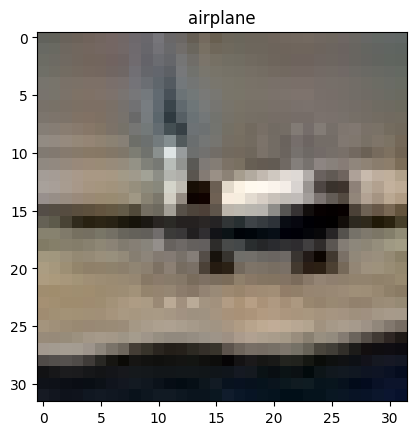

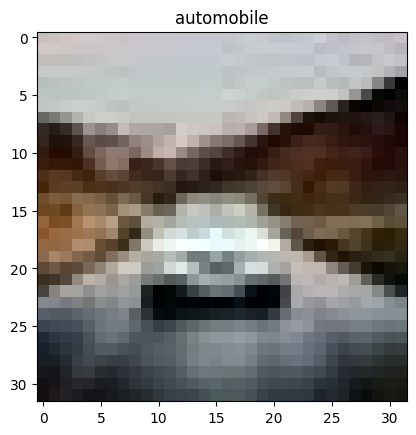

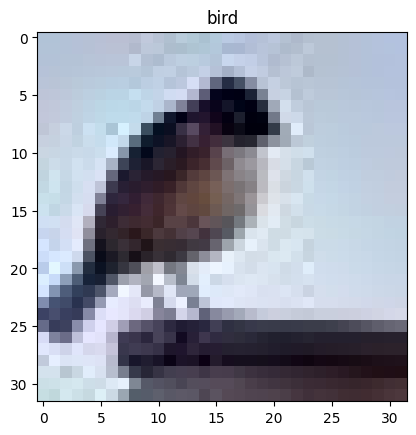

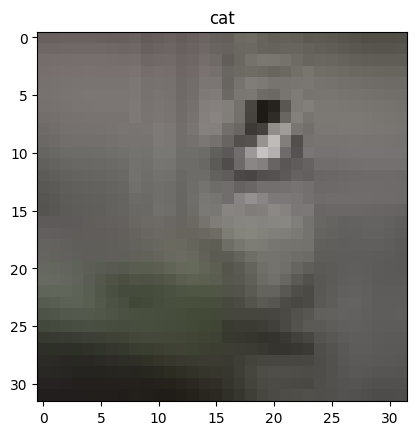

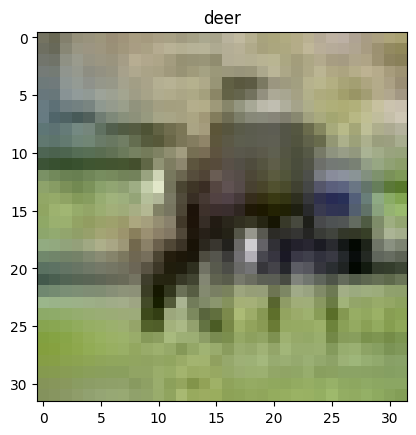

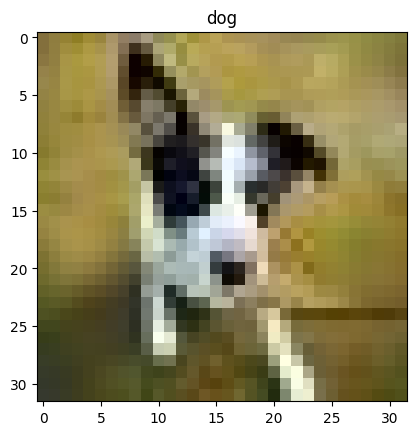

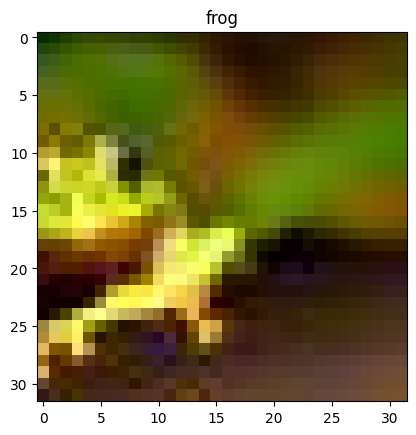

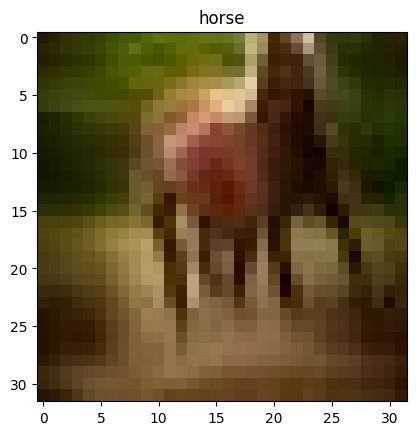

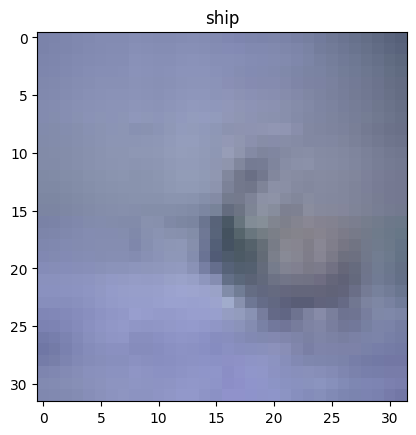

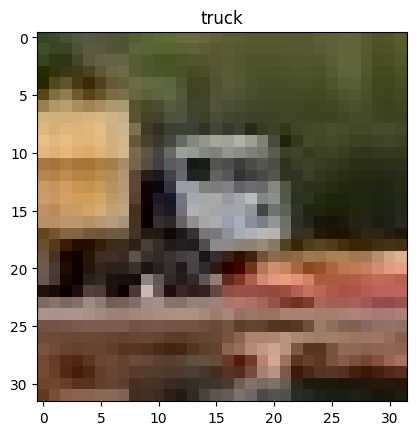

In [53]:
for category in classes:
    verify_classification(category, 0)
